In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Syahrir Ridha\\PycharmProjects\\NET_Solver\\')
import numpy as np
import torch
from geometry import *
from utils import Plot_Grid
from solver import *
from models import *
from mesh import *
from boundary import *
from hard_boundary import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def radial_bipolar(r_out, r_inn, ecc):
    r = r_inn/r_out
    xi_out = np.arccosh( (r*(1+ecc**2) + (1-ecc**2)) / (2*r*ecc) )
    xi_inn = np.arccosh( (r*(1-ecc**2) + (1+ecc**2)) / (2*ecc) )
    c_1 = r_inn*np.sinh(xi_out)
    c_2 = r_out*np.sinh(xi_inn)
    np.testing.assert_allclose(c_1, c_2, rtol=1e-10, atol=0)
    return xi_out, xi_inn, c_1

In [3]:
r_out = 1.0
r_inn = 0.6
ecc = 0.001
xi_out, xi_inn, c = radial_bipolar(r_out,r_inn, ecc)
print(f'Outer Xi: {xi_out} Inner Xi: {xi_inn} Focal Point: {c}')

Outer Xi: 7.8885841413687325 Inner Xi: 7.377758767602808 Focal Point: 799.9995749999124


In [4]:
n = 0.5
tau = 0.1
dpdz = 10

class Gov_Eq(Hard_Solve):
    
    def PDELoss(self, inputs, outputs):
        
        # seperate the inputs
        xi, eta = inputs[:,0], inputs[:,1]
        
        # compute the velocity gradients
        U_grad = self.compute_grad(outputs, inputs)
        du_dxi, du_deta = U_grad[:,0], U_grad[:,1]
        
        # geometric constrains
        a, PSI = self.Geometric_data(xi_inn, xi, eta)
        
        # compute the apparent viscosity
        vis = self.HB_model(du_dxi, du_deta, PSI, a, tau, n)
        
        # compute the left side of governing equation
        left = vis*du_dxi
        
        # compute right side of governing equation
        right = vis*du_deta
        
        # differentiate left side
        d2u_dxi2 = self.compute_grad(left, inputs)[:,0]
        
        # differentiate right side
        d2u_deta2 = self.compute_grad(right, inputs)[:,1]
        
        # combine left and right with non-dimenaiosnal pressure loss
        gov_eq = d2u_dxi2 + d2u_deta2 + dpdz*( a/PSI )**2
        
        return {'PDE': gov_eq}
        
    def HB_model(self, du_dxi, du_deta, PSI, a, tau, n):
        # calculate shear rate
        shear = self.shear_rate(du_dxi, du_deta, PSI)
        
        # calculate the apparent viscosity
        app_vis = (tau/shear)*a + (torch.abs_(shear/a))**(n-1)
        
        return app_vis
    
#     def shear_rate(self, du_dxi, du_deta, PSI, tol = 1e-2):
#         tol = torch.Tensor([tol]).float()
#         shear_ =  torch.sqrt(du_dxi**2 + du_deta**2)
#         shear = torch.where(shear_>= torch.tensor([0.0]).float(), shear_, tol)
#         shear = PSI * shear
#         return torch.abs_(shear)

# define the modified shear rate
    def shear_rate(self, du_dxi, du_deta, PSI, tol = 1e-5):
        
        # calculate the shear rate
        shear_ = torch.sqrt(du_dxi**2 + du_deta**2)
        
        # create mask
        dummy_shear = torch.zeros_like(shear_)
        mask = shear_ <= tol
        indices = torch.nonzero(mask).unsqueeze(1)
        dummy_shear[indices] = tol**2
        shear = torch.sqrt((du_dxi+dummy_shear)**2 + (du_deta+dummy_shear)**2)
        shear = PSI *shear
        #shear = (1/jac)*((dydeta*(dudxi+dummy_shear) - dydxi*(dudeta+dummy_shear))**2 + (dxdxi*(dudeta+dummy_shear) - dxdeta*(dudxi+dummy_shear))**2)**(0.5)
        
        return torch.abs_(shear)
    
    def Geometric_data(self, xi_inn, xi, eta):
        xi_in = torch.Tensor([xi_inn]).float()
        # PSI = cosh(xi) - cos(eta)
        PSI = torch.cosh(xi) - torch.cos(eta)
        # a = sinh(xi_inn)
        a = torch.sinh(xi_in)
        
        return a, PSI
        
# Initialize the PDE equation
pde = Gov_Eq(inputs =('xi', 'eta'), outputs = 'u')

In [5]:
# define the mesh
nx = 60
ny = 60
xi, eta = np.linspace(xi_inn, xi_out, nx), np.linspace(0, np.pi, ny)
mesh = Hard_Mesh({'xi':xi, 'eta':eta})
pde.set_mesh(mesh)

In [18]:
lr = 1e-4
epochs = 500
hid_dim = 200
layers = 11
in_dim = len(pde.inputs)
out_dim = len(pde.outputs)
activation = Sine()
#activation = torch.nn.Tanh()

net = MLP(in_dim, out_dim, layers, hid_dim, act=activation)
#net.apply(_init_weights)

optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = lr, pct_start=0.1, total_steps=epochs)
#scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1,cycle_momentum=True)

pde.compile(net,optimizer, scheduler)

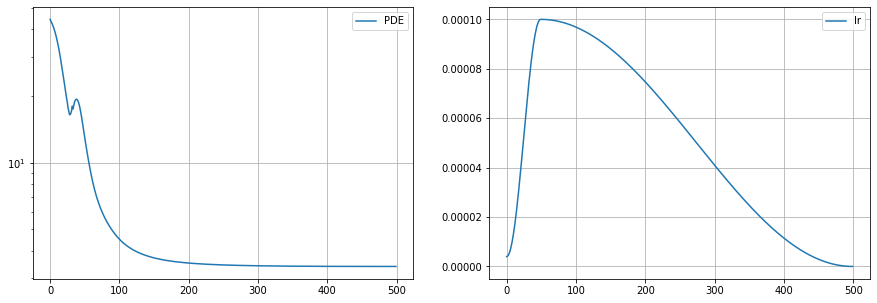

Wall time: 10min 24s


In [19]:
%time hist = pde.hard_solve(nx, ny, epochs)

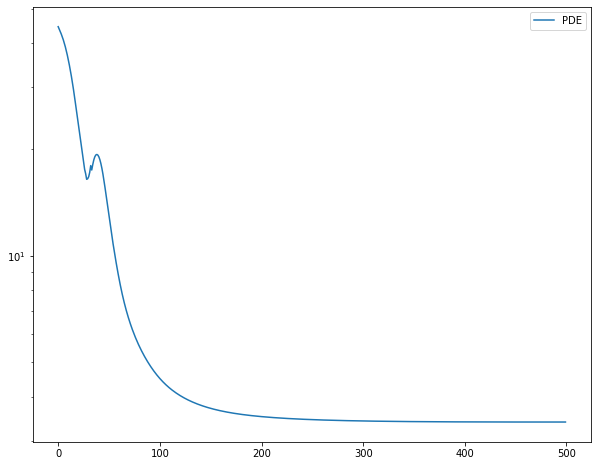

In [20]:
plt.figure(figsize=(10,8))
for key, value in hist.items():
    if key!= 'lr':
        plt.plot(hist[key],label=key)
        plt.legend()
    else:
        pass
    
    plt.yscale('log')

In [21]:
def plot_circle(r_out, r_inn, ecc, sample_space=100):
    # find eta1, eta2, anc c
    eta_1, eta_2, c = radial_bipolar(r_out, r_inn, ecc)
    coth_1 = np.cosh(eta_1)/np.sinh(eta_1)
    coth_2 = np.cosh(eta_2)/ np.sinh(eta_1)
    # find center of both circles
    center_1 = c*coth_1
    center_2 = c*coth_2
    
    # radius of both circles
    rad_1 = c/np.sinh(eta_1)
    rad_2 = c/np.sinh(eta_2)
    
    # define the theta
    theta = powspace(0,np.pi, sample_space)
    
    # define x and y coords
    x_1 = c*np.sinh(eta_1)/( np.cosh(eta_1) - np.cos(theta) )
    y_1 = c*np.sin(theta)/( np.cosh(eta_1) - np.cos(theta) )
    
    x_2 = c*np.sinh(eta_2)/( np.cosh(eta_2) - np.cos(theta) )
    y_2 = c*np.sin(theta)/( np.cosh(eta_2) - np.cos(theta) )
    
    plt.plot(x_1, y_1)
    plt.plot(x_2, y_2)
    plt.axis('equal')

In [27]:
xi = np.linspace(xi_inn, xi_out, nx)
eta = np.linspace(0, np.pi, ny)
eval_mesh = Hard_Mesh({'xi':xi, 'eta':eta})
pred = pde.eval(eval_mesh).view(len(eta),len(xi)).numpy()

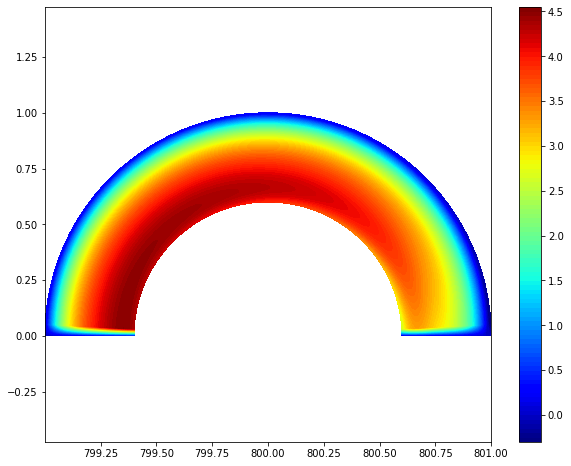

In [28]:
xi, eta = np.meshgrid(xi,eta)
x = c*np.sinh(xi)/( np.cosh(xi) - np.cos(eta) )
y = c*np.sin(eta)/( np.cosh(xi) - np.cos(eta) )
plt.figure(figsize=(10,8))
plt.contourf(x,y, pred.T, 100, cmap='jet')
plt.colorbar()
plt.axis('equal');

In [12]:
pred[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
mesh.data()[:,0].reshape(ny, nx)

In [ ]:
mesh.data()[:,1].reshape(ny, nx)

In [ ]:

net = MLP(in_dim, out_dim, layers, hid_dim, act=activation)
Trial_Solution(ny, nx, net)(mesh.data())